In [6]:
import os
import re
import numpy as np
import h5py
import matplotlib.pyplot as plt
# %matplotlib notebook

import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

def pyplot_set_fontsize(size):
    from matplotlib import pyplot as plt
    small_size = size - 2
    medium_size = size
    bigger_size = size + 2
    plt.rc('font', size=medium_size)         # controls default text sizes
    plt.rc('axes', titlesize=bigger_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=medium_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=small_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=small_size)    # legend fontsize
    plt.rc('figure', titlesize=bigger_size)  # fontsize of the figure title

pyplot_set_fontsize(20)

In [7]:
def get_matching_files(path, file_pattern, sort_by_group=None):
    file_pattern = re.compile(file_pattern)
    matching_files = []
    files = os.listdir(path)
    if sort_by_group is not None:
        group_keys = []
    for filename in files:
        match = file_pattern.match(filename)
        if match:
            matching_files.append(filename)
            if sort_by_group is not None:
                group_keys.append(match.group(sort_by_group))
    if sort_by_group is not None:
        matching_files_and_keys = zip(matching_files, group_keys)
        matching_files_and_keys = sorted(matching_files_and_keys, key=lambda x: int(x[1]))
        matching_files = [x[0] for x in matching_files_and_keys]
    return matching_files

def read_hdf5_files(path, file_pattern, max_steps=None, sort_filenames=True, sort_by_group=None):
    filenames = get_matching_files(path, file_pattern, sort_by_group=sort_by_group)
    if max_steps is None:
        max_steps = 0
        for filename in filenames:
            with h5py.File(os.path.join(path, filename), "r") as f:
                assert(len(f["score"]) == len(f["computed_reward"]))
                assert(len(f["score"]) == len(f["true_reward"]))
                if len(f["score"]) > max_steps:
                    max_steps = len(f["score"])

    scores = np.zeros((len(filenames), max_steps))
    computed_rewards = np.zeros((len(filenames), max_steps))
    true_rewards = np.zeros((len(filenames), max_steps))
    locations = np.zeros((len(filenames), max_steps, 3))
    orientation_rpys = np.zeros((len(filenames), max_steps, 3))
    for i, filename in enumerate(filenames):
        with h5py.File(os.path.join(path, filename), "r") as f:
            steps = f["score"].shape[0]
            if steps > max_steps:
                print("WARNING: Truncating read data from {} steps to {} steps".format(steps, max_steps))
                steps = max_steps
            scores[i, :steps] = f["score"][:steps]
            scores[i, steps:] = f["score"][-1]
            computed_rewards[i, :steps] = f["computed_reward"][:steps]
            true_rewards[i, :steps] = f["true_reward"][:steps]
            locations[i, :steps, :] = f["location"][:steps, :]
            orientation_rpys[i, :steps, :] = f["orientation_rpy"][:steps, :]
    return scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames

In [26]:
def read_data(path, file_patterns, max_steps=None, sort_by_group=None):

    scores = []
    computed_rewards = []
    true_rewards = []
    locations = []
    orientation_rpys = []
    if max_steps is None:
        max_steps = 0
        for file_pattern in file_patterns:
            tmp_scores, _, _, _, _, _ = read_hdf5_files(path, file_pattern)
            max_steps = max(max_steps, tmp_scores.shape[1])
    filenames = []
    for file_pattern in file_patterns:
        tmp_scores, tmp_computed_rewards, tmp_true_rewards, tmp_locations, tmp_orientation_rpys, tmp_filenames \
            = read_hdf5_files(path, file_pattern, max_steps, sort_by_group=sort_by_group)
        scores.append(tmp_scores)
        computed_rewards.append(tmp_computed_rewards)
        true_rewards.append(tmp_true_rewards)
        locations.append(tmp_locations)
        orientation_rpys.append(tmp_orientation_rpys)
        filenames.append(tmp_filenames)

    return scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames

def plot_total_scores(modes, scores_dict, computed_rewards_dict, true_rewards_dict, max_plot_step=None, titles=None, width=12, height=8, normalize_mode=None):
    if width is None:
        plt.figure()
    else:
        plt.figure(figsize=(width, height))
    plt.clf()
#     plt.hold("on")
    legend_entries = []
    if normalize_mode is not None:
        y_distribution = np.array(scores_dict[normalize_mode])
        y_distribution = y_distribution[:, :max_plot_step]
        y_values = np.mean(y_distribution, axis=0)
        normalize_y_factor = 1 / y_values[-1]
    else:
        normalize_y_factor = 1.0
    x_values_list = []
    y_values_list = []
    y_errors_list = []
    mode_list = []
    for i, mode in enumerate(modes):
        y_distribution = np.array(scores_dict[mode])
        if len(y_distribution) == 0:
            continue
        legend_entries.append(mode)
        y_distribution = y_distribution[:, :max_plot_step]
        num_samples = y_distribution.shape[0]
        y_values = np.mean(y_distribution, axis=0)
        y_errors = np.std(y_distribution, axis=0) / np.sqrt(num_samples)
        x_values = np.arange(len(y_values))
        y_values *= normalize_y_factor
        y_errors *= normalize_y_factor
        x_values_list.append(x_values)
        y_values_list.append(y_values)
        y_errors_list.append(y_errors)
        mode_list.append(mode)
    for i, mode in enumerate(mode_list):
        x_values = x_values_list[i]
        y_values = y_values_list[i]
        y_errors = y_errors_list[i]
        plt.errorbar(x_values[::5], y_values[::5], yerr=y_errors[::5])
#         plt.fill_between(x_values, y_values - y_errors, y_values + y_errors,
#             alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
#             linewidth=4, linestyle='dashdot', antialiased=True)
#     plt.hold("off")
    plt.xlabel("# Steps")
    plt.ylabel("Score")
    plt.title("Scores")
    if titles is None:
        titles = legend_entries
    plt.legend(titles, bbox_to_anchor=(-0.05, 1.05), loc=2, borderaxespad=0.)

def plot_score_improvement(modes, baseline, scores_dict, computed_rewards_dict, true_rewards_dict, max_plot_step=None, titles=None, width=12, height=8):
    if width is None:
        plt.figure()
    else:
        plt.figure(figsize=(width, height))
    plt.clf()
#     plt.hold("on")
    legend_entries = []
    for mode in modes:
        if mode == "uniform" or mode == "random" or mode == "heuristic":
            continue
        y_distribution = np.array(scores_dict[mode])
        if len(y_distribution) == 0:
            continue
        legend_entries.append(mode)
        y_distribution = y_distribution[:, :max_plot_step]
        num_samples = y_distribution.shape[0]
        y_values = np.mean(y_distribution, axis=0)
        y_errors = np.std(y_distribution, axis=0) / np.sqrt(num_samples)
        x_values = np.arange(len(y_values))
        y_values -= baseline[:max_plot_step]
    #     plt.plot(x_values, y_values)
#         plt.errorbar(x_values, y_values, yerr=y_errors)
        plt.errorbar(x_values[::5], y_values[::5], yerr=y_errors[::5])

        #y_values -= baseline
        #y_values = y_values[:, :max_plot_step]
        #plt.plot(np.arange(y_values.shape[1]), np.mean(y_values, axis=0))
#     plt.hold("off")
    plt.xlabel("# Steps")
    plt.ylabel("Score difference")
    plt.title("Score above baseline (heuristic)")
    if titles is None:
        titles = legend_entries
    plt.legend(titles, bbox_to_anchor=(0.85, 1.05), loc=2, borderaxespad=0.)

def plot_auc_score_vs_time(modes, scores_dict, max_plot_step=None, titles=None, width=12, height=8, normalize_mode=None):
    if width is None:
        plt.figure()
    else:
        plt.figure(figsize=(width, height))
    plt.clf()
#     plt.hold("on")
    all_values = []
    all_num_samples = []
    xtick_labels = []
    for mode in modes:
        y_values = np.array(scores_dict[mode])
        if len(y_values) == 0:
            continue
        xtick_labels.append(mode)
        num_samples = y_values.shape[0]
        y_values = y_values[:, :max_plot_step]
        y_values = np.sum(y_values, axis=1)
#         y_values /= float(max_plot_step)
        y_value = np.mean(y_values, axis=0)
        y_error = np.std(y_values, axis=0) / np.sqrt(num_samples)
#         print(mode, max_plot_step, num_samples, y_values.shape, y_value, y_error)
#         print(mode)
#         print(y_values)
#         print(y_value)
#         print(y_error)
        all_values.append((mode, y_value, y_error))
        all_num_samples.append(num_samples)
    x_values = np.arange(len(all_values))
    modes = [mode for mode, y_value, y_error in all_values]
    y_values = [y_value for mode, y_value, y_error in all_values]
    y_errors = [y_error for mode, y_value, y_error in all_values]
    if normalize_mode is not None:
        idx = modes.index(normalize_mode)
        assert idx >= 0
        normalize_y_value = y_values[idx]
        print("Normalization value: {}".format(normalize_y_value))
        norm_y_values = y_values / normalize_y_value
        norm_y_errors = y_errors / normalize_y_value
    else:
        norm_y_values = y_values
        norm_y_errors = y_errors
#     print(modes)
#     print(y_values)
#     print(y_errors)
    plt.bar(x_values, norm_y_values, yerr=norm_y_errors)
    if titles is None:
        titles = modes
    plt.xticks(x_values, titles, rotation=45)
#     plt.hold("off")
    plt.xlabel("mode")
    plt.ylabel("AUC")
    plt.title("AUC")
    for i, mode in enumerate(modes):
        print("mode={}, samples={}, AUC={}, error={}, unnorm_AUC={}, unnorm_error={}".format(mode, all_num_samples[i], norm_y_values[i], norm_y_errors[i], y_values[i], y_errors[i]))

def assert_poses_are_equal(locations_dict, orientation_rpys_dict, ignore_if_empty=True):
    modes = list(locations_dict.keys())
    max_step_length = np.iinfo(np.int32).max
    ref_mode = None
    for j, mode in enumerate(modes):
        if ignore_if_empty and locations_dict[modes[j]].shape[0] == 0:
            continue
        ref_mode = mode
        max_step_length = min([max_step_length, locations_dict[modes[j]].shape[0]])

    print("max_step_length={}".format(max_step_length))
    for i in range(max_step_length):
        for j, mode in enumerate(modes):
            if ignore_if_empty and locations_dict[modes[j]].shape[0] == 0:
                continue
            locations_all_close = np.allclose(locations_dict[ref_mode][i, 0, :], locations_dict[modes[j]][i, 0, :], rtol=1e-4, atol=1e-4)
            orientations_rpy_all_close = np.allclose(orientation_rpys_dict[ref_mode][i, 0, :], orientation_rpys_dict[modes[j]][i, 0, :], rtol=1e-4, atol=1e-4)
            if not locations_all_close or not orientations_rpy_all_close:
                print("locations: {}, {}".format(locations_dict[ref_mode][i, 0, :], locations_dict[modes[j]][i, 0, :]))
                print("orientations_rpy: {}, {}".format(orientation_rpys_dict[ref_mode][i, 0, :], orientation_rpys_dict[modes[j]][i, 0, :]))
            assert locations_all_close, "Assertion failed for i={}, j={}, ref_mode={}, mode={}".format(i, j, ref_mode, modes[j])
            assert orientations_rpy_all_close, "Assertion failed for i={}, j={}, ref_mode={}, mode={}".format(i, j, ref_mode, modes[j])


(50, 201)
(50, 201)


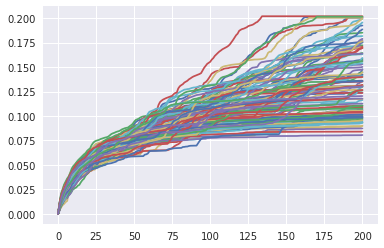

In [5]:
# Check of poses for 100 and 200 step runs

#
# Reading data
#

# save_plots = True
save_plots = False

# modes = [
#     "steps_100_model_0040_prediction",
#     "steps_100_oracle",
#     "steps_100_rpg_ig_RearSideEntropyIg",
#     "steps_100_rpg_ig_ProximityCountIg",
#     "steps_100_rpg_ig_VasquezGomezAreaFactorIg",
#     "steps_100_uniform",
#     "steps_100_random",
# ]
mode1 = "model_0040_prediction"
mode2 = "oracle"
# mode2 = mode1
mode3 = "stereo_model_0040_prediction_stereo_0.50"
modes = [mode1, mode2, mode3]


# scene_id = "20"
scene_id = "buildings3_large_steps_200"
max_plot_step = 200
path = "outputs_scenes/output_small_camera_new"
plot_path = "outputs_scenes/plots_small_camera"

# Pattern for hdf5 files with episodes
# file_patterns = ["output{:s}_{:s}_.+.hdf5".format(scene_id, mode) for mode in modes]
file_patterns = ["output{:s}_{:s}_([0-9]{{1,4}})\.hdf5".format(scene_id, mode) for mode in modes]

scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames = read_data(path, file_patterns, sort_by_group=1)
scores_dict = {mode: scores[i] for i, mode in enumerate(modes)}
computed_rewards_dict = {mode: computed_rewards[i] for i, mode in enumerate(modes)}
true_rewards_dict = {mode: true_rewards[i] for i, mode in enumerate(modes)}
locations_dict = {mode: locations[i] for i, mode in enumerate(modes)}
orientation_rpys_dict = {mode: orientation_rpys[i] for i, mode in enumerate(modes)}

#
# Plotting
#

print(scores_dict[mode1].shape)
print(scores_dict[mode2].shape)
plt.figure()
plt.plot(scores_dict[mode1].T);
plt.plot(scores_dict[mode2].T);

ref_mode = modes[0]

# print(locations_dict[mode1].shape)
# print(locations_dict[mode2].shape)
# print(locations_dict[mode3].shape)
for i in range(min([locations_dict[mode].shape[0] for mode in modes])):
    for j, mode in enumerate(modes):
        all_close = np.allclose(locations_dict[ref_mode][i, 0, :], locations_dict[modes[j]][i, 0, :], rtol=1e-4, atol=1e-4)
        if not all_close:
            print(locations_dict[ref_mode][i, 0, :])
            print(locations_dict[modes[j]][i, 0, :])
        assert all_close, "Assertion failed for i={}, j={}, ref_mode={}, mode={}".format(i, j, ref_mode, modes[j])

# assert_poses_are_equal(locations_dict, orientation_rpys_dict)
# locations_dict2 = locations_dict
# i = 2
# j = 90
# print(locations_dict["steps_100_oracle"][i, j, :])
# print(locations_dict2["steps_200_oracle"][i, j, :])
# for i in range(1, 50):
#     j = 0
#     assert np.allclose(locations_dict["steps_100_oracle"][i, j, :], locations_dict2["steps_200_oracle"][i, j, :], rtol=1e-4, atol=1e-4), "i={}, j={}".format(i, j)
#     for j in range(100):
#         assert np.allclose(locations_dict["steps_100_oracle"][i, j, :], locations_dict2["steps_200_oracle"][i, j, :], rtol=1e-4, atol=1e-4), "i={}, j={}".format(i, j)

(50, 101)


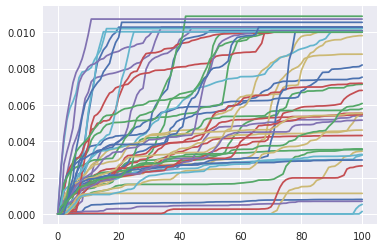

In [317]:
# Individual traces

#
# Reading data
#

# save_plots = True
save_plots = False

# modes = [
#     "steps_100_model_0040_prediction",
#     "steps_100_oracle",
#     "steps_100_rpg_ig_RearSideEntropyIg",
#     "steps_100_rpg_ig_ProximityCountIg",
#     "steps_100_rpg_ig_VasquezGomezAreaFactorIg",
#     "steps_100_uniform",
#     "steps_100_random",
# ]
mode = "steps_100_model_0040_prediction"
modes = [mode]

scene_id = "20"
max_plot_step = 100
path = "outputs_scenes/output_small_camera"
plot_path = "outputs_scenes/plots_small_camera"

# Pattern for hdf5 files with episodes
file_patterns = ["output{:s}_{:s}_([0-9]{{1,4}})\.hdf5".format(scene_id, mode) for mode in modes]

scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames = read_data(path, file_patterns, sort_by_group=1)
scores_dict = {mode: scores[i] for i, mode in enumerate(modes)}
computed_rewards_dict = {mode: computed_rewards[i] for i, mode in enumerate(modes)}
true_rewards_dict = {mode: true_rewards[i] for i, mode in enumerate(modes)}
locations_dict = {mode: locations[i] for i, mode in enumerate(modes)}
orientation_rpys_dict = {mode: orientation_rpys[i] for i, mode in enumerate(modes)}

#
# Plotting
#

print(scores_dict[mode].shape)
plt.figure()
plt.plot(scores_dict[mode].T);


model_0040_prediction (2, 1001)
oracle (4, 1001)


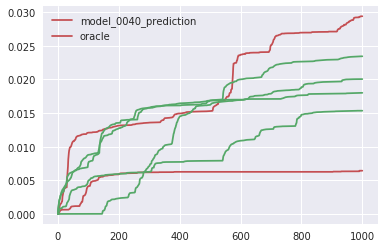

In [356]:
# Individual traces of 1000 steps

#
# Reading data
#

# save_plots = True
save_plots = False

modes = [
    "model_0040_prediction",
    "oracle",
]

scene_id = "20"
max_plot_step = 1000
path = "outputs_scenes/output_small_camera_single"
plot_path = "outputs_scenes/plots_small_camera"

# Pattern for hdf5 files with episodes
file_patterns = ["output{:s}_{:s}_([0-9]{{1,4}})\.hdf5".format(scene_id, mode) for mode in modes]

scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames = read_data(path, file_patterns, sort_by_group=1)
scores_dict = {mode: scores[i] for i, mode in enumerate(modes)}
computed_rewards_dict = {mode: computed_rewards[i] for i, mode in enumerate(modes)}
true_rewards_dict = {mode: true_rewards[i] for i, mode in enumerate(modes)}
locations_dict = {mode: locations[i] for i, mode in enumerate(modes)}
orientation_rpys_dict = {mode: orientation_rpys[i] for i, mode in enumerate(modes)}

#
# Plotting
#

plt.figure()
colors = ["r", "g", "b"]
legend_entries = []
for i, mode in enumerate(modes):
    print(mode, scores_dict[mode].shape)
    plt.plot(scores_dict[mode].T, colors[i]);
    legend_entries.append(mode)
plt.legend(legend_entries);


In [10]:
import itertools

def do_plots(scene_ids, path, max_plot_step, max_episode=None, plot_path=None, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=False, modes=None, titles=None,
             width=12, height=8, normalize_mode=None):
    #
    # Reading data
    #

    save_plots = plot_path is not None

    if modes is None:
        modes = [
            "model_0078_prediction",
            "model_0240_prediction",
            "model_0140_prediction",
            "model_0040_prediction",
            "model_0072_prediction",
            "model_0073_prediction",
            "model_0074_prediction",
            "model_0075_prediction",
            "model_0040_prediction_traj",
    #         "model_0040_prediction_noise_0.05_0.00",
    #         "model_0040_prediction_noise_0.05_0.05",
    #         "model_0040_prediction_noise_0.05_0.10",
    #         "model_0040_prediction_noise_0.10_0.00",
    #         "model_0040_prediction_noise_0.10_0.05",
    #         "model_0040_prediction_noise_0.10_0.10",
    #         "model_0040_prediction_noise_0.20_0.00",
    #         "model_0040_prediction_noise_0.20_0.05",
    #         "model_0040_prediction_noise_0.20_0.10",
    #         "model_0040_prediction_noise_0.50_0.10",
            "model_0040_prediction_noise_0.05_0.00_traj",
            "model_0040_prediction_noise_0.05_0.05_traj",
            "model_0040_prediction_noise_0.05_0.10_traj",
            "model_0040_prediction_noise_0.10_0.00_traj",
            "model_0040_prediction_noise_0.10_0.05_traj",
            "model_0040_prediction_noise_0.10_0.10_traj",
            "model_0040_prediction_noise_0.20_0.00_traj",
            "model_0040_prediction_noise_0.20_0.05_traj",
            "model_0040_prediction_noise_0.20_0.10_traj",
            "model_0040_prediction_noise_0.50_0.25_traj",

            "model_0140_prediction_noise_0.05_0.00_traj",
            "model_0140_prediction_noise_0.05_0.05_traj",
            "model_0140_prediction_noise_0.05_0.10_traj",
            "model_0140_prediction_noise_0.10_0.00_traj",
            "model_0140_prediction_noise_0.10_0.05_traj",
            "model_0140_prediction_noise_0.10_0.10_traj",
            "model_0140_prediction_noise_0.20_0.00_traj",
            "model_0140_prediction_noise_0.20_0.05_traj",
            "model_0140_prediction_noise_0.20_0.10_traj",
            "model_0140_prediction_noise_0.50_0.25_traj",

            "oracle_noise_0.05_0.10_traj",
            "oracle_noise_0.10_0.10_traj",
            "oracle_noise_0.20_0.10_traj",

            "stereo_model_0040_prediction_stereo_bm_0.50",
            "stereo_model_0040_prediction_stereo_bm_0.25",
            "stereo_model_0040_prediction_stereo_bm_0.20",
            "stereo_bm_model_0040_prediction_stereo_bm_0.50",
            "stereo_bm_model_0040_prediction_stereo_bm_0.25",
            "stereo_bm_model_0040_prediction_stereo_bm_0.20",
            "stereo_model_0040_prediction_stereo_sgbm_0.50",
            "stereo_model_0040_prediction_stereo_sgbm_0.25",
            "stereo_model_0040_prediction_stereo_sgbm_0.20",
            "stereo_sgbm_model_0040_prediction_stereo_sgbm_0.50",
            "stereo_sgbm_model_0040_prediction_stereo_sgbm_0.25",
            "stereo_sgbm_model_0040_prediction_stereo_sgbm_0.20",
            "stereo_sgbm_0.2_model_0040_prediction_stereo_sgbm_0.20",

            "stereo_sgbm_rpg_ig_ProximityCountIg_stereo_sgbm_0.50",
            "stereo_sgbm_oracle_stereo_sgbm_0.50",
            "stereo_sgbm_random_stereo_sgbm_0.50",
            "stereo_sgbm_uniform_stereo_sgbm_0.50",

            "stereo_sgbm_rpg_ig_ProximityCountIg_stereo_sgbm_0.50_traj",
            "stereo_sgbm_oracle_stereo_sgbm_0.50_traj",
            "stereo_sgbm_random_stereo_sgbm_0.50_traj",
            "stereo_sgbm_uniform_stereo_sgbm_0.50_traj",

            "stereo_model_0040_prediction_stereo_bm_0.50_traj",
            "stereo_model_0040_prediction_stereo_bm_0.25_traj",
            "stereo_model_0040_prediction_stereo_bm_0.20_traj",
            "stereo_bm_model_0040_prediction_stereo_bm_0.50_traj",
            "stereo_bm_model_0040_prediction_stereo_bm_0.25_traj",
            "stereo_bm_model_0040_prediction_stereo_bm_0.20_traj",
            "stereo_model_0040_prediction_stereo_sgbm_0.50_traj",
            "stereo_model_0040_prediction_stereo_sgbm_0.25_traj",
            "stereo_model_0040_prediction_stereo_sgbm_0.20_traj",
            "stereo_sgbm_model_0040_prediction_stereo_sgbm_0.50_traj",
            "stereo_sgbm_model_0040_prediction_stereo_sgbm_0.25_traj",
            "stereo_sgbm_model_0040_prediction_stereo_sgbm_0.20_traj",
            "stereo_sgbm_0.2_model_0040_prediction_stereo_sgbm_0.20_traj",
            "model_0040_prediction_2step",
            "model_0040_prediction_3step",
            "oracle",
            "oracle_traj",
            "rpg_ig_RearSideEntropyIg",
            "rpg_ig_ProximityCountIg",
            "rpg_ig_VasquezGomezAreaFactorIg",
            "uniform",
            "random",
        ]

        if not isinstance(scene_ids, list):
            scene_ids = [scene_ids]

        # Pattern for hdf5 files with episodes
        keys = list([scene_id + "_" + mode for scene_id, mode in itertools.product(scene_ids, modes)])
        file_patterns = ["output{:s}_{:s}_([0-9]{{1,4}})\.hdf5".format(scene_id, mode) for scene_id, mode in itertools.product(scene_ids, modes)]
    else:
        keys = modes
        file_patterns = ["output{:s}_([0-9]{{1,4}})\.hdf5".format(mode) for mode in modes]

    scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames = read_data(path, file_patterns, max_steps=max_plot_step, sort_by_group=1)
    if max_episode is not None:
        for i in range(len(modes)):
            scores[i] = scores[i][:max_episode]
            computed_rewards[i] = computed_rewards[i][:max_episode]
            true_rewards[i] = true_rewards[i][:max_episode]
            locations[i] = locations[i][:max_episode]
            orientation_rpys[i] = orientation_rpys[i][:max_episode]
            filenames[i] = filenames[i][:max_episode]
    scores_dict = {key: scores[i] for i, key in enumerate(keys)}
    computed_rewards_dict = {key: computed_rewards[i] for i, key in enumerate(keys)}
    true_rewards_dict = {key: true_rewards[i] for i, key in enumerate(keys)}
    locations_dict = {key: locations[i] for i, key in enumerate(keys)}
    orientation_rpys_dict = {key: orientation_rpys[i] for i, key in enumerate(keys)}

    if plot_path is not None:
        obj = {"keys": keys, "scores_dict": scores_dict}
        import pickle
        with open(os.path.join(plot_path, "scene_{}_plot_data.pickle".format(scene_ids[0])), "wb") as fout:
            pickle.dump(obj, fout)
#         import scipy.io
#         scipy.io.savemat(os.path.join(plot_path, "scene_{}_plot_data.mat".format(scene_ids[0])), obj, long_field_names=True)
#         obj2 = scipy.io.loadmat(os.path.join(plot_path, "scene_{}_plot_data.mat".format(scene_ids[0])))
        from pybh import hdf5_utils
        hdf5_utils.write_numpy_dict_to_hdf5_file(os.path.join(plot_path, "scene_{}_plot_data.h5".format(scene_ids[0])), scores_dict)

    print("poses_should_be_equal={}".format(poses_should_be_equal))
    if poses_should_be_equal:
        print("calling poses_should_be_equal()")
        assert_poses_are_equal(locations_dict, orientation_rpys_dict)

    #
    # Plotting
    #

    for key in keys:
        print("Mode: {}".format(key))
        print("  Number of episodes: {}".format(scores_dict[key].shape[0]))
        print("  Average computed rewards: {}".format(np.mean(computed_rewards_dict[key])))
        print("  Average true rewards: {}".format(np.mean(true_rewards_dict[key])))

    plot_auc_score_vs_time(keys, scores_dict, max_plot_step=max_plot_step, titles=titles, width=width, height=height, normalize_mode=normalize_mode)
    if save_plots:
        plt.savefig(os.path.join(plot_path, "scene_{}_auc_score_vs_time.png".format(scene_ids[0])))

    plot_total_scores(keys, scores_dict, computed_rewards_dict, true_rewards_dict, max_plot_step=max_plot_step, titles=titles, width=width, height=height,
                      normalize_mode=normalize_mode)
    if save_plots:
        plt.savefig(os.path.join(plot_path, "scene_{}_total_score.png".format(scene_ids[0])))

    if baseline_mode is not None:
        if baseline_mode not in keys:
            baseline_mode = scene_ids[0] + "_" + baseline_mode
        baseline = np.zeros(list(scores_dict.values())[0].shape)
        # baseline = np.mean(scores_dict["heuristic"], axis=0)
        # baseline = np.mean(scores_dict["uniform"], axis=0)
        baseline = np.mean(scores_dict[baseline_mode], axis=0)
        # baseline = np.mean(scores_dict["steps_100_oracle"], axis=0)
        plot_score_improvement(keys, baseline, scores_dict, computed_rewards_dict, true_rewards_dict, max_plot_step=max_plot_step, titles=titles, width=width, height=height)
        if save_plots:
            plt.savefig(os.path.join(plot_path, "scene_{}_score_improvement.png".format(scene_ids[0])))

    # mode = "model_0009_prediction"
    # print("Average abs error:", np.mean(np.abs(computed_rewards_dict[mode] - true_rewards_dict[mode])))
    # print("RMS error:", np.sqrt(np.mean(np.square(computed_rewards_dict[mode] - true_rewards_dict[mode]))))


poses_should_be_equal=True
calling poses_should_be_equal()
max_step_length=14
Mode: model_0040_prediction
  Number of episodes: 50
  Average computed rewards: 50.74132608777226
Mode: model_0040_prediction_noise_0.05_0.00
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.05_0.05
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.05_0.10
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.10_0.00
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.10_0.05
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.10_0.10
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.20_0.00
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_prediction_noise_0.20_0.05
  Number of episodes: 0
  Average computed rewards: nan
Mode: model_0040_predic

/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


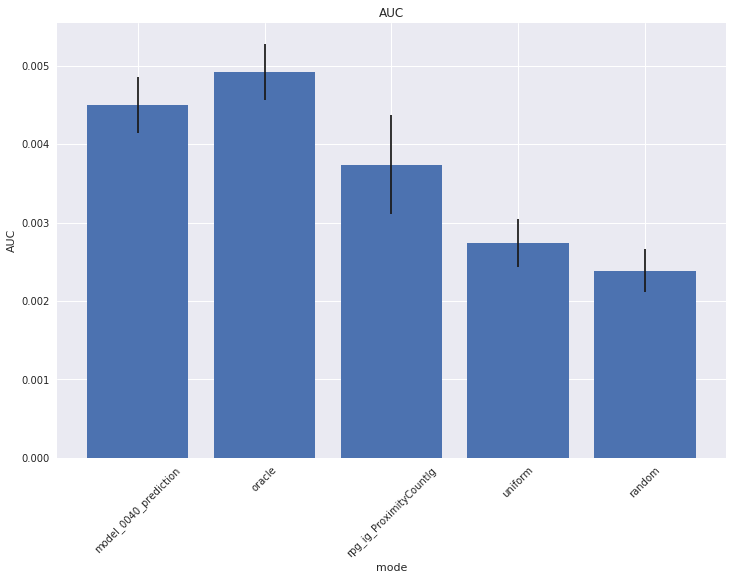

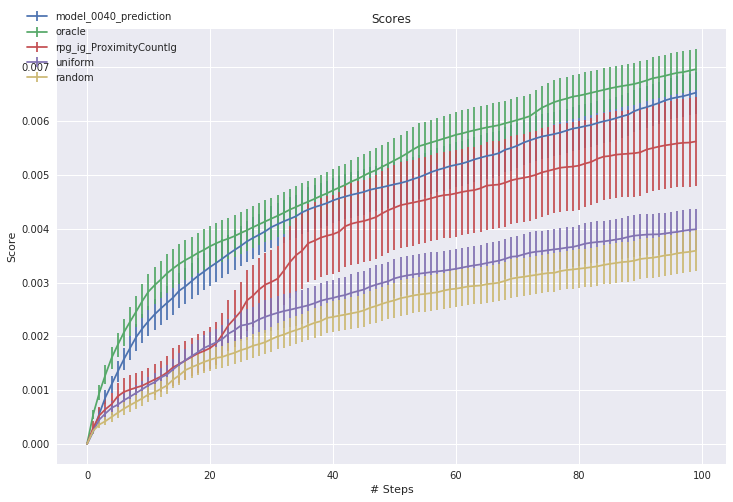

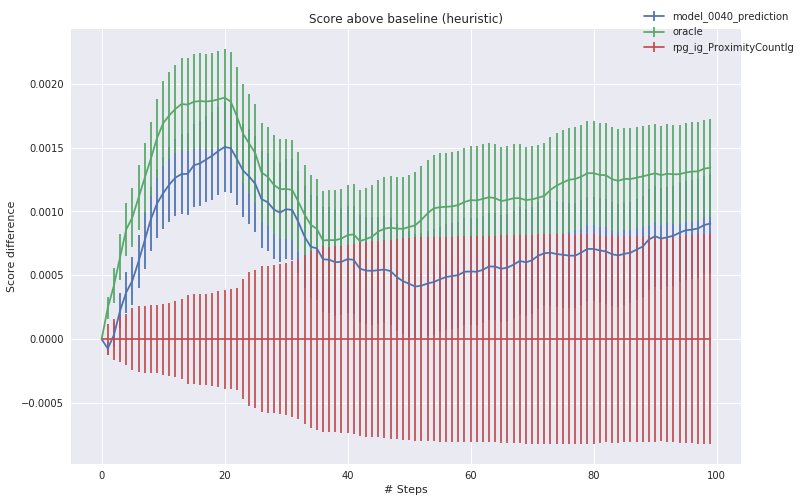

In [403]:
# scene_20_steps_100

scene_id = "20_steps_100"
max_plot_step = 100
path = "outputs_scenes/output_small_camera_new"
plot_path = "outputs_scenes/plots_small_camera"
plot_path = None
do_plots(scene_id, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=True)


poses_should_be_equal=True
calling poses_should_be_equal()
max_step_length=50
Mode: 20_steps_200_oracle
  Number of episodes: 50
  Average computed rewards: 351.8662540643325
  Average true rewards: 351.8662540643325
Mode: 20_steps_200_model_0040_prediction
  Number of episodes: 50
  Average computed rewards: 789.7396511098757
  Average true rewards: 340.9816244219566
Mode: 20_steps_200_32_model_0140_prediction
  Number of episodes: 50
  Average computed rewards: 996.2235448018354
  Average true rewards: 302.43599736378786
Mode: 20_steps_200_rpg_ig_ProximityCountIg
  Number of episodes: 50
  Average computed rewards: 95350.78348258707
  Average true rewards: 285.95619145902424
Normalization value: 7.410440697663838
mode=20_steps_200_oracle, samples=50, AUC=1.0, error=0.04730876659566797, unnorm_AUC=7.410440697663838, unnorm_error=0.3505788093368174
mode=20_steps_200_model_0040_prediction, samples=50, AUC=0.9606740366198988, error=0.04485451026157097, unnorm_AUC=7.119017978157099, unnor

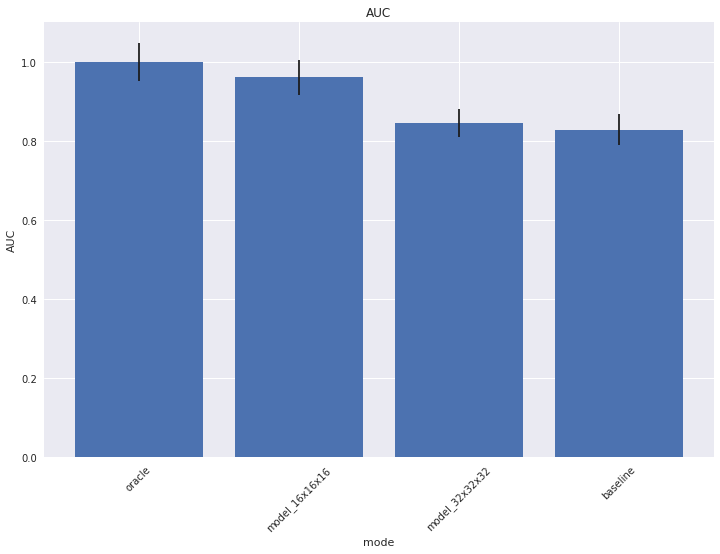

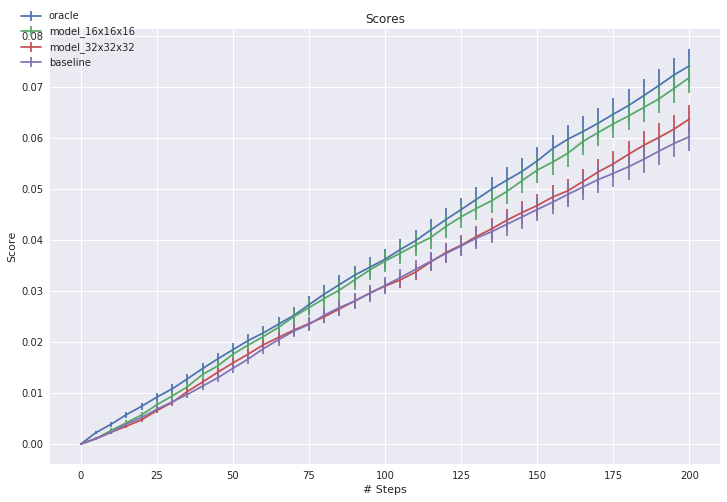

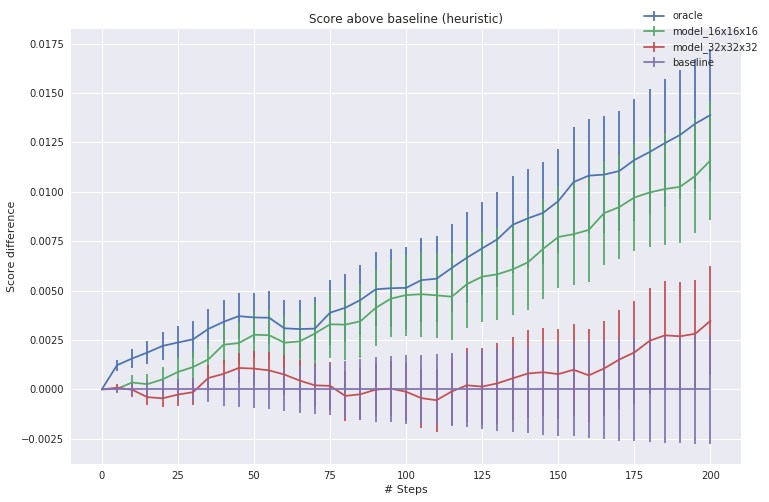

In [98]:
# scene_20_steps_200

scene_ids = ["20_steps_200", "20_steps_200_32"]
max_plot_step = 201
# path = "outputs_scenes/output_small_camera"
path = "outputs_scenes/output_small_camera_fixed"
plot_path = "outputs_scenes/figures_small_camera"
# plot_path = None
modes = ["20_steps_200_oracle",
         "20_steps_200_model_0040_prediction",
         "20_steps_200_32_model_0140_prediction",
         "20_steps_200_rpg_ig_ProximityCountIg"]
titles = ["oracle", "model_16x16x16", "model_32x32x32", "baseline"]
# modes = None
# titles = None
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=True, max_episode=50, modes=modes, titles=titles,
#         width=6, height=4)
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=True, max_episode=50, modes=modes, titles=titles)
do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=True, max_episode=50, modes=modes, titles=titles,
        normalize_mode="20_steps_200_oracle")


poses_should_be_equal=True
calling poses_should_be_equal()
max_step_length=50
Mode: 30_steps_200_oracle
  Number of episodes: 50
  Average computed rewards: 243.46474208472344
  Average true rewards: 243.4647420846997
Mode: 30_steps_200_model_0040_prediction
  Number of episodes: 50
  Average computed rewards: 584.4365867349046
  Average true rewards: 222.42962904451554
Mode: 30_steps_200_32_model_0140_prediction
  Number of episodes: 50
  Average computed rewards: 764.2540425574839
  Average true rewards: 227.5598440949226
Mode: 30_steps_200_rpg_ig_ProximityCountIg
  Number of episodes: 50
  Average computed rewards: 90611.29701492537
  Average true rewards: 150.3304204364815
Normalization value: 5.824069335385566
mode=30_steps_200_oracle, samples=50, AUC=1.0, error=0.0328414100010717, unnorm_AUC=5.824069335385566, unnorm_error=0.19127064891806655
mode=30_steps_200_model_0040_prediction, samples=50, AUC=0.8689788268797771, error=0.02939923370258949, unnorm_AUC=5.060992938729832, unnor

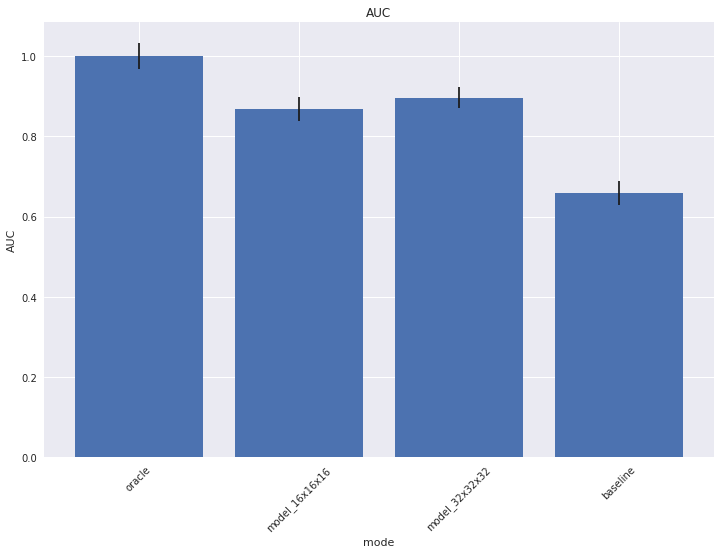

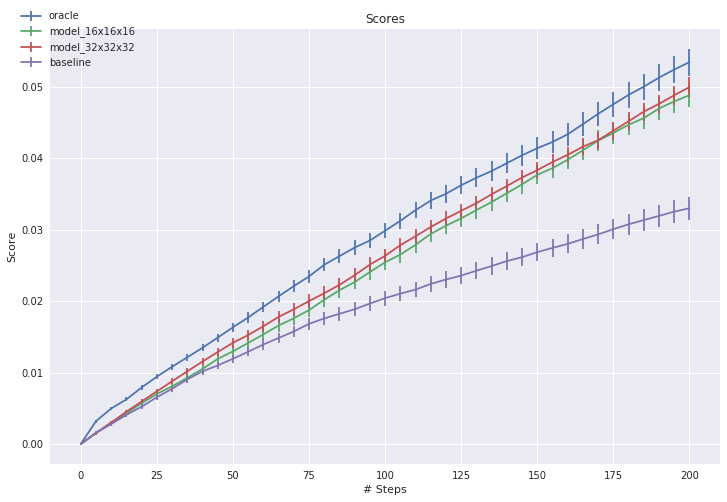

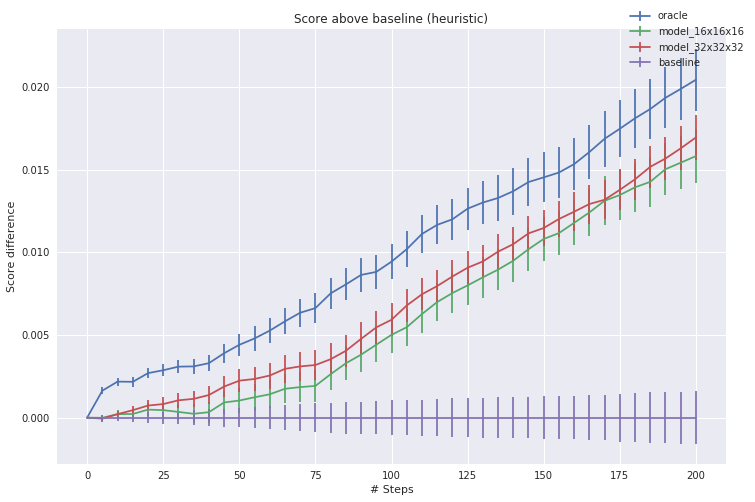

In [96]:
# scene_30_steps_200

scene_ids = ["30_steps_200", "30_steps_200_32"]
max_plot_step = 201
# path = "outputs_scenes/output_small_camera"
path = "outputs_scenes/output_small_camera_fixed"
plot_path = "outputs_scenes/figures_small_camera"
# plot_path = None
modes = ["30_steps_200_oracle",
         "30_steps_200_model_0040_prediction",
         "30_steps_200_32_model_0140_prediction",
         "30_steps_200_rpg_ig_ProximityCountIg"]
titles = ["oracle", "model_16x16x16", "model_32x32x32", "baseline"]
# modes = None
# titles = None
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=True, max_episode=50, modes=modes, titles=titles)
do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=True, max_episode=50, modes=modes, titles=titles,
        normalize_mode="30_steps_200_oracle")


poses_should_be_equal=False
Mode: 20_steps_200_large_motion_model_0078_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: 20_steps_200_large_motion_model_0240_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: 20_steps_200_large_motion_model_0140_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: 20_steps_200_large_motion_model_0040_prediction
  Number of episodes: 50
  Average computed rewards: 32.44356545899045
  Average true rewards: 40.89072441014254
Mode: 20_steps_200_large_motion_model_0072_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: 20_steps_200_large_motion_model_0073_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: 20_steps_200_large_motion_model_0074_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Ave

/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


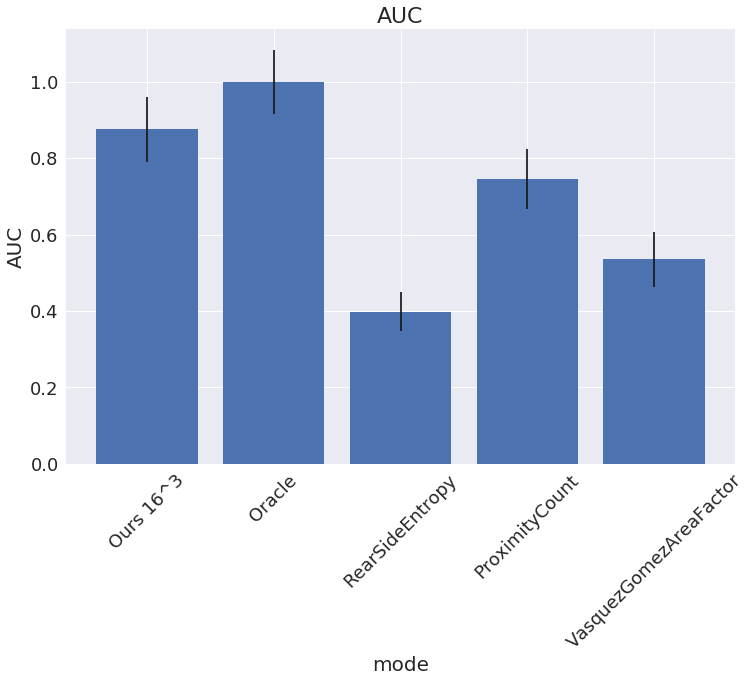

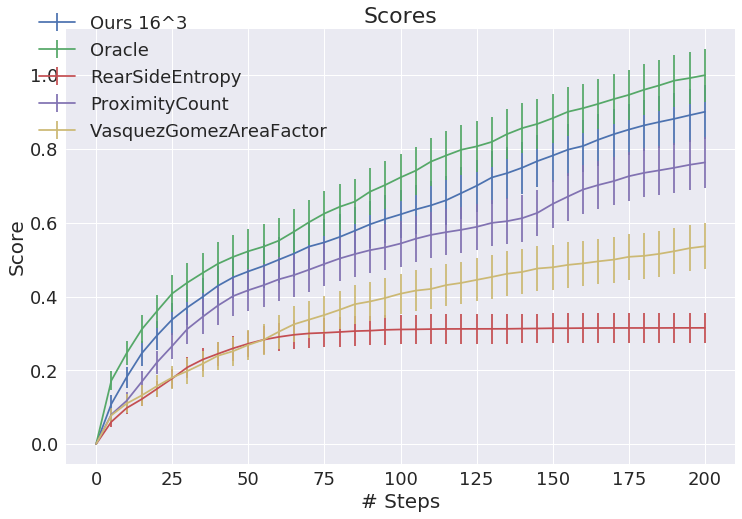

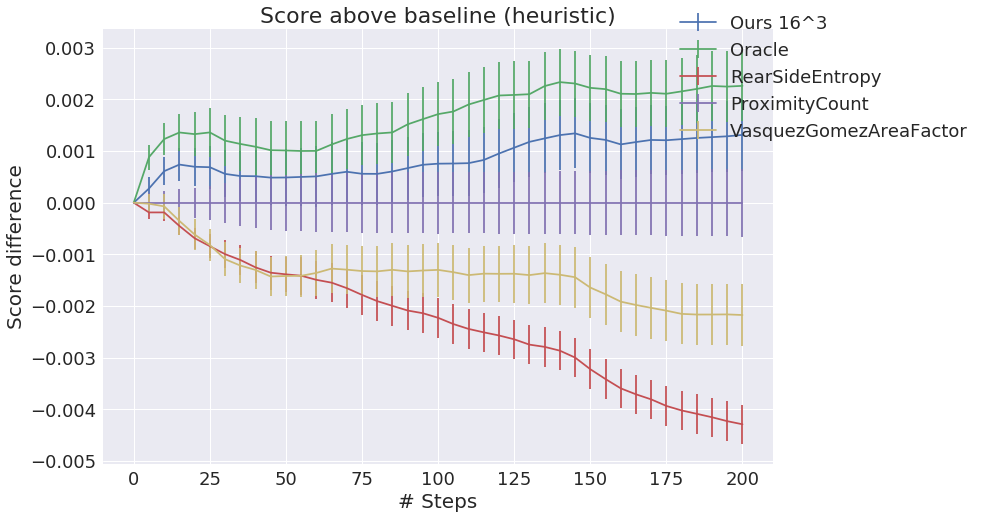

In [27]:
# scene_20_steps_200_large_motion

scene_ids = ["20_steps_200_large_motion"]
max_plot_step = 201
# path = "outputs_scenes/output_small_camera"
path = "outputs_scenes/output_small_camera_new"
plot_path = "outputs_scenes/figures_small_camera"
# plot_path = None
titles = ["Ours 16^3", "Oracle", "RearSideEntropy", "ProximityCount", "VasquezGomezAreaFactor"]
# modes = None
# titles = None
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=False, modes=modes, titles=titles)
do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=False, modes=modes, titles=titles,
        normalize_mode="20_steps_200_large_motion_oracle")


poses_should_be_equal=False
Mode: buildings3_large_steps_200_model_0078_prediction
  Number of episodes: 50
  Average computed rewards: 92.54500970717093
  Average true rewards: 35.19358817114077
Mode: buildings3_large_steps_200_model_0240_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: buildings3_large_steps_200_model_0140_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: buildings3_large_steps_200_model_0040_prediction
  Number of episodes: 50
  Average computed rewards: 125.95369996939132
  Average true rewards: 37.76021692908609
Mode: buildings3_large_steps_200_model_0072_prediction
  Number of episodes: 50
  Average computed rewards: 183.1560337503158
  Average true rewards: 38.6291645163961
Mode: buildings3_large_steps_200_model_0073_prediction
  Number of episodes: 50
  Average computed rewards: 73.18858817622436
  Average true rewards: 36.458263534499395
Mode: buildings3_larg

/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


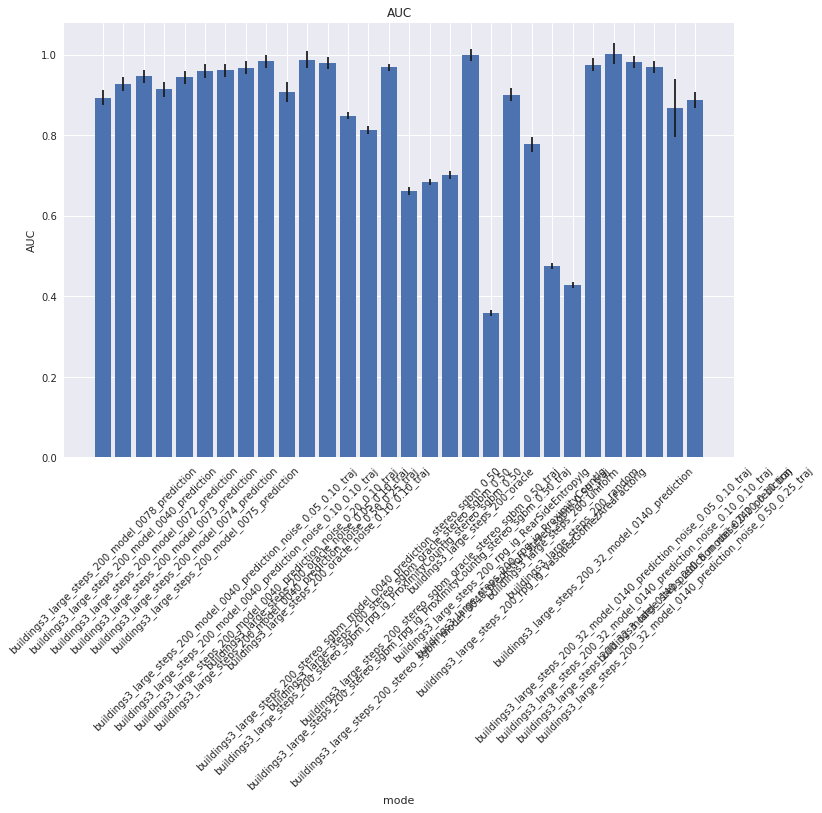

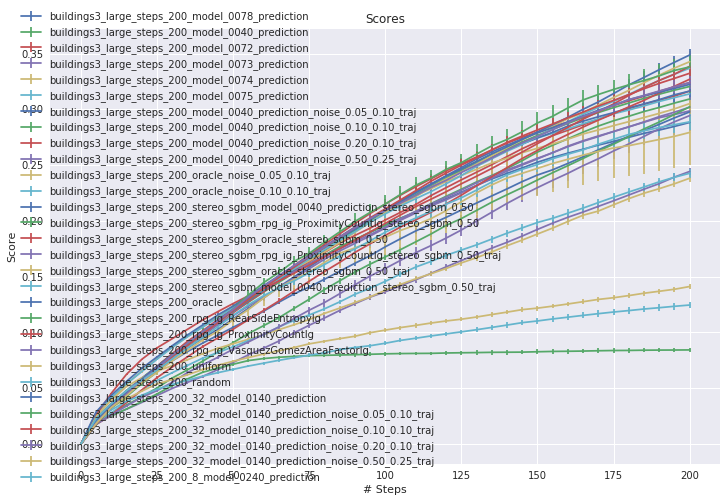

In [114]:
# buildings3_large_steps_200

scene_ids = ["buildings3_large_steps_200", "buildings3_large_steps_200_32", "buildings3_large_steps_200_8"]
max_plot_step = 201
# path = "outputs_scenes/output_small_camera_new"
# path = "outputs_scenes/output_small_camera_fixed"
path = "outputs_scenes/output_small_camera_fixed"
# path = "outputs_scenes/output_small_camera_stereo"
# path = "outputs_scenes/output_small_camera_trajectory"
plot_path = "outputs_scenes/figures_small_camera"
plot_path = None
modes = [
        "buildings3_large_steps_200_oracle",
         "buildings3_large_steps_200_model_0040_prediction",
         "buildings3_large_steps_200_32_model_0140_prediction",
         "buildings3_large_steps_200_rpg_ig_ProximityCountIg",
#          "buildings3_large_steps_200_eta_3_oracle",
#          "buildings3_large_steps_200_eta_3_model_0040_prediction",
#          "buildings3_large_steps_200_32_eta_3_model_0140_prediction",
#          "buildings3_large_steps_200_eta_3_rpg_ig_ProximityCountIg",
        ]
# modes = ["buildings3_large_steps_200_eta_3_oracle",
#          "buildings3_large_steps_200_eta_3_model_0040_prediction",
#          "buildings3_large_steps_200_32_eta_3_model_0140_prediction",
#          "buildings3_large_steps_200_eta_3_rpg_ig_ProximityCountIg"]
# titles = ["oracle", "model_16x16x16", "model_32x32x32", "baseline"]
# scene_ids = ["buildings3_large_steps_200"]
# modes = ["buildings3_large_steps_200_stereo_sgbm_0.2_model_0040_prediction_stereo_sgbm_0.20_traj"]
# modes = ["buildings3_large_steps_200_stereo_sgbm_0.2_model_0040_prediction_stereo_sgbm_0.20_traj", "buildings3_large_steps_200_model_0040_prediction"]
modes=None
titles=None
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode=None, poses_should_be_equal=False, max_episode=50, modes=modes, titles=titles)
do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode=None, poses_should_be_equal=False, max_episode=50, modes=modes, titles=titles,
        normalize_mode="buildings3_large_steps_200_oracle")
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode=None, poses_should_be_equal=False, max_episode=None, modes=modes, titles=titles)

#mode=buildings3_large_steps_200_model_0040_prediction, AUC=0.0933423263278324, error=0.0020056309137934463
#mode=buildings3_large_steps_200_stereo_model_0040_prediction_stereo_sgbm_0.50_traj, AUC=0.10345247638057917, error=0.001122050480619661
#mode=buildings3_large_steps_200_oracle, AUC=0.10101452760579993, error=0.002004324871193052


poses_should_be_equal=False
Mode: buildings7_large_steps_200_model_0078_prediction
  Number of episodes: 50
  Average computed rewards: 100.43328792861445
  Average true rewards: 50.16166146443448
Mode: buildings7_large_steps_200_model_0240_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: buildings7_large_steps_200_model_0140_prediction
  Number of episodes: 0
  Average computed rewards: nan
  Average true rewards: nan
Mode: buildings7_large_steps_200_model_0040_prediction
  Number of episodes: 50
  Average computed rewards: 83.3233735134827
  Average true rewards: 52.044638555864516
Mode: buildings7_large_steps_200_model_0072_prediction
  Number of episodes: 50
  Average computed rewards: 282.4446123296349
  Average true rewards: 53.000453413124404
Mode: buildings7_large_steps_200_model_0073_prediction
  Number of episodes: 45
  Average computed rewards: 161.93615072771223
  Average true rewards: 56.85969587831225
Mode: buildings7_la

/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/bhepp/.virtualenvs/rl_reconstruct3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


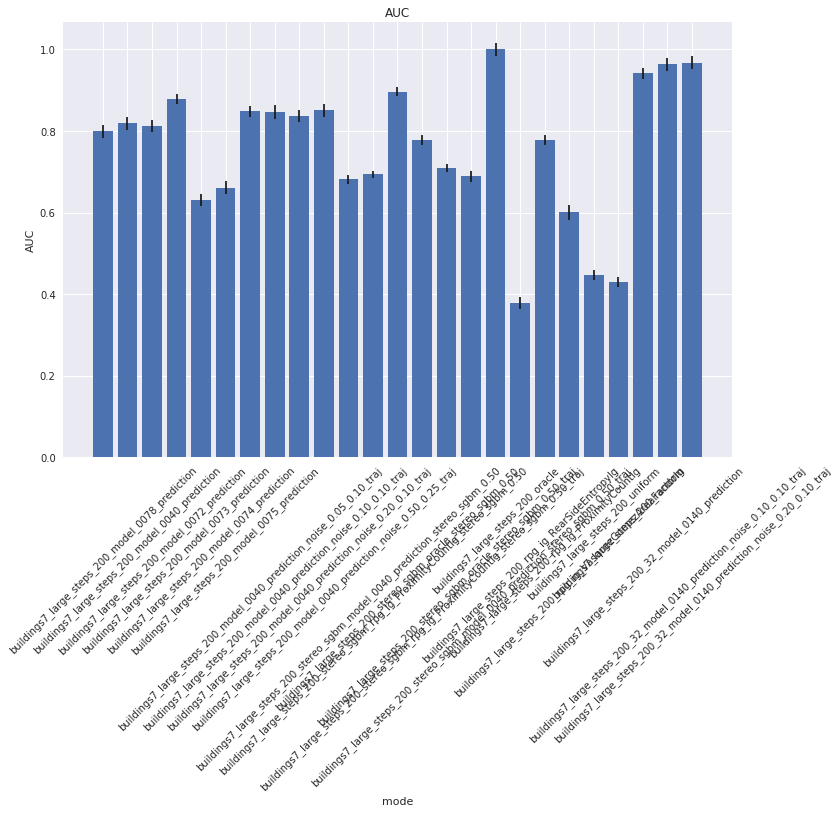

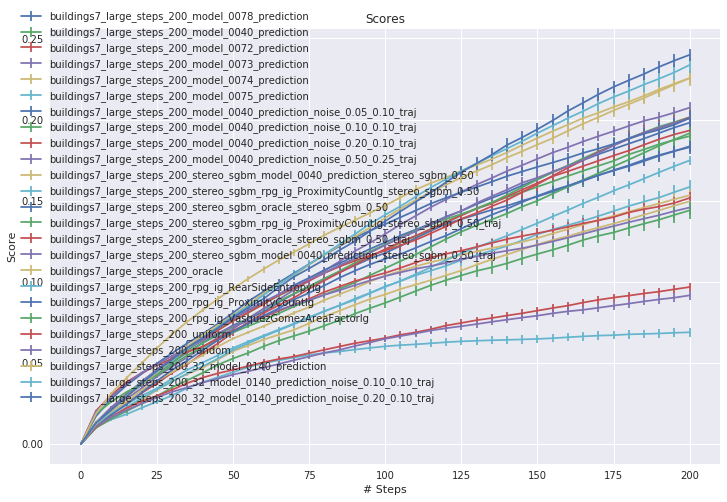

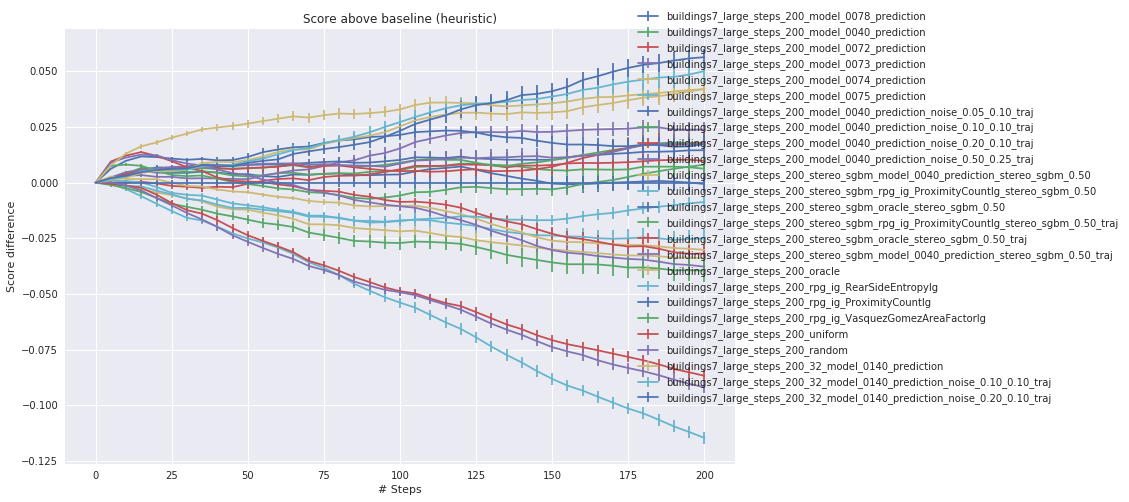

In [113]:
# buildings7_large_steps_200

scene_ids = ["buildings7_large_steps_200", "buildings7_large_steps_200_32"]
max_plot_step = 201
# path = "outputs_scenes/output_small_camera_new"
path = "outputs_scenes/output_small_camera_fixed"
plot_path = "outputs_scenes/figures_small_camera"
plot_path = None
modes = ["buildings7_large_steps_200_oracle",
         "buildings7_large_steps_200_model_0040_prediction",
         "buildings7_large_steps_200_32_model_0140_prediction",
         "buildings7_large_steps_200_rpg_ig_ProximityCountIg"]
titles = ["oracle", "model_16x16x16", "model_32x32x32", "baseline"]
modes=None
titles=None
# do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=False, modes=modes, titles=titles)
do_plots(scene_ids, path, max_plot_step, plot_path=plot_path, baseline_mode="rpg_ig_ProximityCountIg", poses_should_be_equal=False, max_episode=50, modes=modes, titles=titles,
        normalize_mode="buildings7_large_steps_200_oracle")


In [16]:
scores = scores_dict["model_0018_prediction"][...,:max_plot_step]
y_distribution = np.array(scores)
y_distribution = y_distribution[:, :max_plot_step]
num_samples = y_distribution.shape[0]
y_values = np.mean(y_distribution, axis=0)
y_errors = np.std(y_distribution, axis=0) / np.sqrt(num_samples)
x_values = np.arange(len(y_values))
# y_values -= baseline[:max_plot_step]
#     plt.plot(x_values, y_values)
# plt.errorbar(x_values, y_values, yerr=y_errors)
y_distribution[...,-1]
np.sum(y_distribution[...,-1]<0.4)

# scores_dict[modes[0]].shape

# Compute area under the score/time curve
auc = np.sum(scores)

KeyError: 'model_0018_prediction'

In [288]:
#
# Reading data
#

max_plot_step = 250
scene_id = "1"
modes = [
#     "model_0004_prediction",
#     "model_0005_prediction",
#     "model_0006_prediction",
    "model_0007_prediction",
    "model_0008_prediction",
    "model_0009_prediction",
    "model_0010_prediction",
    "oracle",
    "oracle_2step",
#     "oracle_3step",
#     "heuristic",
#     "rpg_ig_OcclusionAwareIg",
#     "rpg_ig_UnobservedVoxelIg",
#     "rpg_ig_AverageEntropyIg",
#     "rpg_ig_RearSideVoxelIg",
#     "rpg_ig_RearSideEntropyIg",
    "rpg_ig_ProximityCountIg",
#     "rpg_ig_VasquezGomezAreaFactorIg",
    "uniform",
    "random",
]
file_patterns = ["output{:s}_{:s}_.+.hdf5".format(scene_id, mode) for mode in modes]
path = "output"
# path = "output_rpg_ig"

scores, computed_rewards, true_rewards, locations, orientation_rpys = read_data(path, file_patterns)
scores_dict = {mode: scores[i] for i, mode in enumerate(modes)}
computed_rewards_dict = {mode: computed_rewards[i] for i, mode in enumerate(modes)}
true_rewards_dict = {mode: true_rewards[i] for i, mode in enumerate(modes)}
locations_dict = {mode: locations[i] for i, mode in enumerate(modes)}
orientation_rpys_dict = {mode: orientation_rpys[i] for i, mode in enumerate(modes)}

#
# Plotting
#

for mode in modes:
    print("Mode: {}".format(mode))
    print("  Number of episodes: {}".format(scores_dict[mode].shape[0]))
    print("  Average computed rewards: {}".format(np.mean(computed_rewards_dict[mode])))



Mode: model_0007_prediction
  Number of episodes: 51
  Average computed rewards: 1.91476002738
Mode: model_0008_prediction
  Number of episodes: 51
  Average computed rewards: 2.03749359433
Mode: model_0009_prediction
  Number of episodes: 51
  Average computed rewards: 1.970457692
Mode: model_0010_prediction
  Number of episodes: 51
  Average computed rewards: 1.84978888603
Mode: oracle
  Number of episodes: 196
  Average computed rewards: 2.15867087709
Mode: oracle_2step
  Number of episodes: 25
  Average computed rewards: 1.72429487987
Mode: rpg_ig_ProximityCountIg
  Number of episodes: 50
  Average computed rewards: 2035.25640719
Mode: uniform
  Number of episodes: 150
  Average computed rewards: 0.948982035928
Mode: random
  Number of episodes: 150
  Average computed rewards: 0.0


In [305]:
def plot_trajectories(modes, locations_dict, index):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.clf()
    plt.hold("on")
    legend_entries = []
    for mode in modes:
        locations = locations_dict[mode]
        if len(locations) == 0:
            continue
        x_values = locations[index, :, 0]
        y_values = locations[index, :, 1]
        plt.plot(x_values, y_values)
        legend_entries.append(mode)
    plt.hold("off")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(legend_entries, bbox_to_anchor=(-0.05, 1.05), loc=2, borderaxespad=0.)

def plot_trajectory_with_colored_time(modes, locations_dict, mode, index, max_steps):
    from matplotlib.collections import LineCollection

    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.clf()
    legend_entries = []
    locations = locations_dict[mode]
    x_values = locations[index, :max_steps, 0]
    y_values = locations[index, :max_steps, 1]

    points = np.array([x_values, y_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('hot'), norm=plt.Normalize(0, 1))
    lc.set_array(np.arange(x_values.shape[0]) / float(x_values.shape[0]))
    lc.set_linewidth(2)

    plt.gca().add_collection(lc)
#     plt.xlim([-100, 100])
#     plt.ylim([-100, 100])
    plt.gca().autoscale(enable=True, axis="both")

#         plt.plot(x_values, y_values)
    legend_entries.append(mode)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(legend_entries, bbox_to_anchor=(-0.05, 1.05), loc=2, borderaxespad=0.)

# def plot_trajectories_kde(modes, locations_dict):
#     width = 12
#     height = 8
#     plt.figure(figsize=(width, height))
#     plt.clf()
#     plt.hold("on")
#     locations = np.concatenate(locations_dict["rpg_ig_VasquezGomezAreaFactorIg"], axis=0)
#     xy_table = locations[:, 0:2]
#     print(xy_table.shape)
#     print(np.std(xy_table[:, 0]))
#     df = pd.DataFrame(xy_table, columns=["x", "y"])
# #     sns.kdeplot(locations[1, :, 0], locations[1, :, 1])
#     sns.jointplot(x="x", y="y", data=df, kind="kde", n_levels=160, shade=True,
#                  xlim=[-10, 10], ylim=[-10, 10])
#     plt.hold("off")
#     plt.xlabel("x")
#     plt.ylabel("y")
#     plt.legend(legend_entries, bbox_to_anchor=(-0.05, 1.05), loc=2, borderaxespad=0.)

# plot_trajectories(modes, locations_dict, index=5)
# plot_trajectory_with_colored_time(modes, locations_dict, mode="rpg_ig_ProximityCountIg", index=11, max_steps=160)
# plot_trajectories_kde(modes, locations_dict)
# plt.savefig(os.path.join(plot_path, "trajectory_{}.png".format(scene_id)))


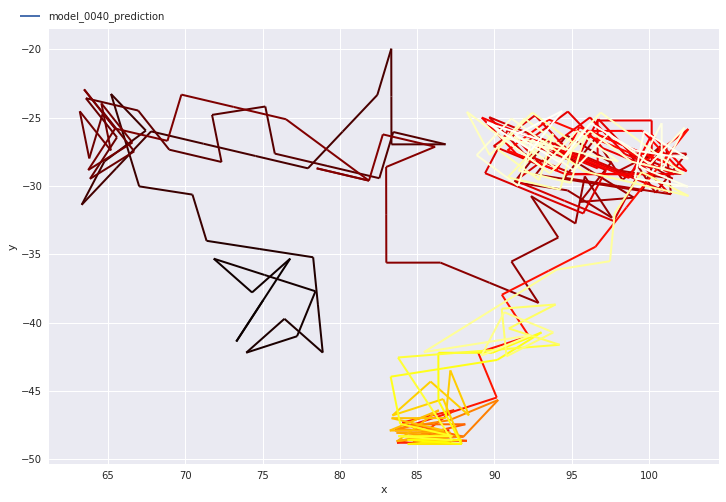

In [384]:
# Individual traces of 1000 steps

#
# Reading data
#

# save_plots = True
save_plots = False

modes = [
    "model_0040_prediction",
    "oracle",
]

scene_id = "20"
max_plot_step = 1000
path = "outputs_scenes/output_small_camera_single"
plot_path = "outputs_scenes/plots_small_camera"

# Pattern for hdf5 files with episodes
file_patterns = ["output{:s}_{:s}_([0-9]{{1,4}})\.hdf5".format(scene_id, mode) for mode in modes]

scores, computed_rewards, true_rewards, locations, orientation_rpys, filenames = read_data(path, file_patterns, sort_by_group=1)
scores_dict = {mode: scores[i] for i, mode in enumerate(modes)}
computed_rewards_dict = {mode: computed_rewards[i] for i, mode in enumerate(modes)}
true_rewards_dict = {mode: true_rewards[i] for i, mode in enumerate(modes)}
locations_dict = {mode: locations[i] for i, mode in enumerate(modes)}
orientation_rpys_dict = {mode: orientation_rpys[i] for i, mode in enumerate(modes)}

# plot_trajectories(modes, locations_dict, index=0)
plot_trajectory_with_colored_time(modes, locations_dict, mode="model_0040_prediction", index=0, max_steps=1000)
